In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

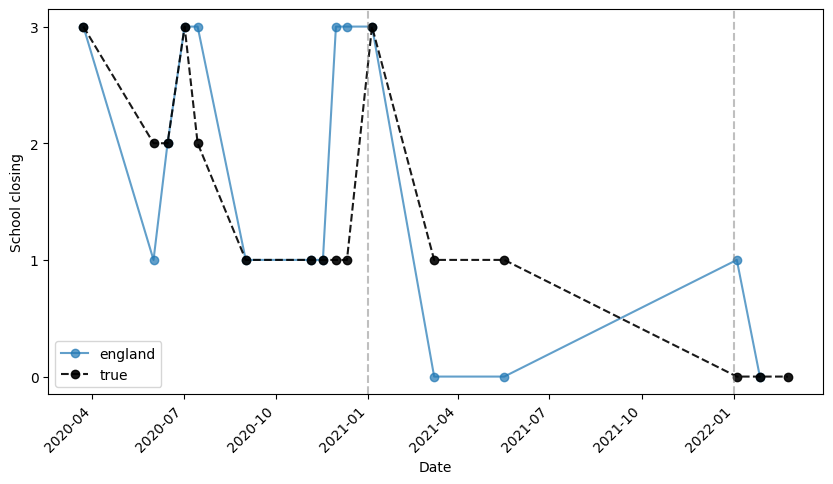

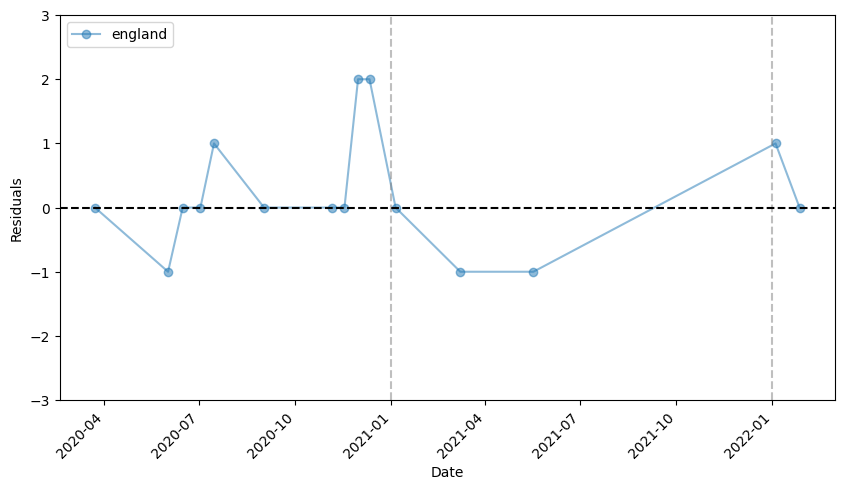

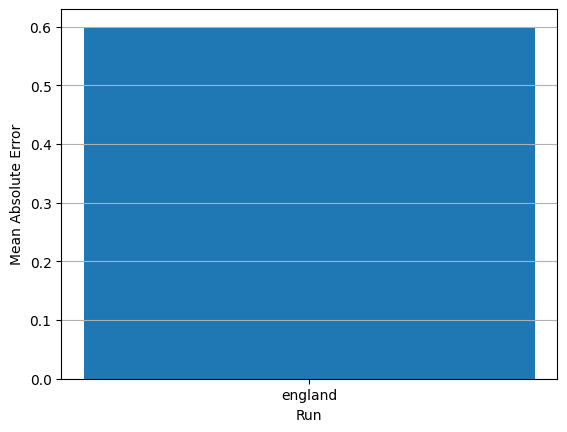

In [184]:
def compare_results(results_dirs: dict[str, str], label_path: str):

    fig, ax = plt.subplots(figsize=(10, 5))

    labels = pd.read_csv(label_path)
    labels["Date"] = pd.to_datetime(labels["Date"])
    labels = labels.sort_values(by="Date")
    labels["Score"] = labels["Score"].astype(int)

    resid_dict = {}

    for label, path in results_dirs.items():
        preds = pd.read_csv(path)
        preds["Date"] = pd.to_datetime(preds["Date"])
        preds = preds.sort_values(by="Date")

        preds["Score"] = preds["Score"].fillna("0")
        preds["Score"] = preds["Score"].astype(str)
        valid_scores = ["0", "1", "2", "3"]
        # any score not in valid scores should be set to 0
        preds["Score"] = preds["Score"].apply(lambda x: x if x in valid_scores else "0")
        preds["Score"] = preds["Score"].astype(int)

        resid_dict[label] = preds["Score"] - labels["Score"]

        ax.plot(preds["Date"], preds["Score"], marker="o", alpha=0.7, label=label)

    ax.plot(labels["Date"], labels["Score"], marker="o", color="black", alpha=0.9, linestyle="--", label="true")

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks([0, 1, 2, 3])
    ax.set_ylabel("School closing")

    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    for label, residuals in resid_dict.items():
        ax.plot(labels["Date"], residuals, marker="o", alpha=0.5, label=label)

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axhline(0, color="black", linestyle="--")

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylabel("Residuals")

    plt.show()

    mae_dict = dict(resid_dict)
    for label in mae_dict:
        mae_dict[label] = mae_dict[label].abs().mean()
    fig, ax = plt.subplots()
    ax.grid(axis="y")
    ax.bar(mae_dict.keys(), mae_dict.values(), color=[f"C{i}" for i in range(len(mae_dict))])
    ax.set_ylabel("Mean Absolute Error")
    ax.set_xlabel("Run")

    plt.show()


compare_results(
    {"england": "persistence.csv"},
    "england.csv"
)

0.13415723406774943
0.4969696969696969
0.08187427930973512
0.4666666666666667


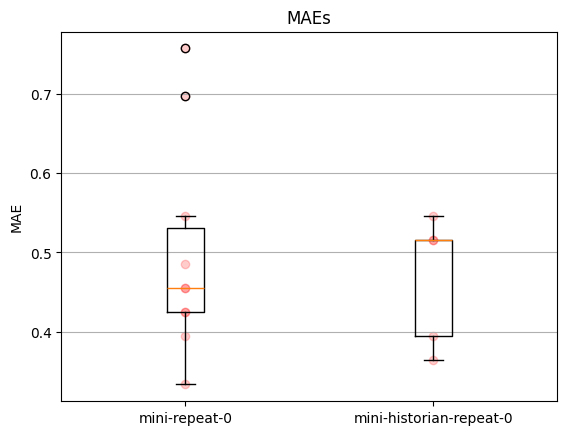

In [142]:
def compare_repeats(all_results_paths: list[list[str]], label_path: str):
    labels = pd.read_csv(label_path)
    labels["Date"] = pd.to_datetime(labels["Date"])


    fig, ax = plt.subplots()
    for i, results_paths in enumerate(all_results_paths):

        errors = []
        for results_path in results_paths:
            preds = pd.read_csv(results_path)
            preds["Date"] = pd.to_datetime(preds["Date"])
            valid_scores = ["0", "1", "2", "3"]
            preds["Score"] = preds["Score"].astype(str).apply(lambda x: x if x in valid_scores else "0")
            preds["Score"] = preds["Score"].astype(int)

            merged = labels.merge(preds, on="Date", how="left", suffixes=("", "_Pred")).copy()
            merged["Score_Pred"] = merged["Score_Pred"].fillna(0)
            error = merged["Score_Pred"] - merged["Score"]
            mae = error.abs().mean()
            errors.append(mae)
        
        stdev = pd.Series(errors).std()
        print(stdev)
        mean = pd.Series(errors).mean()
        print(mean)

        ax.boxplot(errors, positions=[i+1])
        ax.scatter([i+1] * len(errors), errors, color="red", alpha=0.2)

    ax.set_title("MAEs")
    ax.set_ylabel("MAE")
    x_names = [r[0].split("/")[-2] for r in all_results_paths]
    ax.set_xticks(range(1, len(x_names)+1), x_names)
    ax.grid(axis="y")

    plt.show()

repeats = [
    [f"../logs/mini-repeat-{i}/persistence.csv" for i in range(10)],
    [f"../logs/mini-historian-repeat-{i}/persistence.csv" for i in range(5)],
]

compare_repeats(repeats, "uk.csv")

    

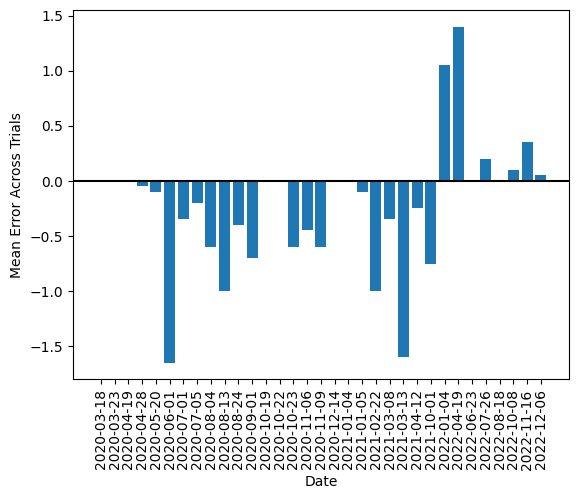

In [154]:
def question_average_correctness(results_paths: list[str], label_path: str):
    labels = pd.read_csv(label_path)
    labels["Date"] = pd.to_datetime(labels["Date"])

    all_errors = []
    for path in results_paths:
        preds = pd.read_csv(path)
        preds["Date"] = pd.to_datetime(preds["Date"])
        preds["Score"] = preds["Score"].astype(str).apply(lambda x: x if x in ["0", "1", "2", "3"] else "0")
        preds["Score"] = preds["Score"].astype(int)

        merged = labels.merge(preds, on="Date", how="left", suffixes=("", "_Pred")).copy()
        merged["Score_Pred"] = merged["Score_Pred"].fillna(0)
        error = merged["Score_Pred"] - merged["Score"]
        all_errors.append(error.to_list())

    all_errors = np.array(all_errors)
    mean_question_errors = np.mean(all_errors, axis=0)

    fig, ax = plt.subplots()
    ax.bar(range(len(mean_question_errors)), mean_question_errors)
    ax.set_xlabel("Date")
    ax.set_ylabel("Mean Error Across Trials")
    ax.axhline(0, color="black")
    ax.set_xticks(range(len(mean_question_errors)), labels["Date"].apply(lambda x: x.date()), rotation=90)
    plt.show()

question_average_correctness(repeats[0] + repeats[1], "uk.csv")

In [185]:
def get_wrong_with_notes(results_path: str, label_path: str):
    preds = pd.read_csv(results_path)
    labels = pd.read_csv(label_path)

    labels["Date"] = pd.to_datetime(labels["Date"])
    preds["Date"] = pd.to_datetime(preds["Date"])

    labels = labels.merge(preds[["Date", "Score", "Notes"]], on="Date", how="left", suffixes=("", "_Pred"))

    wrong = labels[labels["Score"] != labels["Score_Pred"]]
    for _, row in wrong.iterrows():
        print(row["Date"].date(), row["Score_Pred"], row["Score"])
        print("\t", row["Notes_Pred"])
        print("\t", row["Notes"])

get_wrong_with_notes("persistence.csv", "england.csv")

2020-06-01 1.0 2.0
	 The articles indicate a transition to phased reopening, with some year groups returning while significant operational changes and safety concerns remain, reflecting a partial closure status.
	 Boris Johnson said the government intended to reopen then for early years pupils, Reception, Year 1 and Year 6.       Government source: https://web.archive.org/web/20200713101829/https://www.gov.uk/government/publications/preparing-for-the-wider-opening-of-schools-from-1-june    BBC News Source: https://web.archive.org/web/20200713101448/https://www.bbc.com/news/education-52792769
2020-07-15 3.0 2.0
	 The score of 3 reflects mandatory school closures in Leicester due to COVID-19, as confirmed by multiple articles, including the GOV.UK and Leicester City Council articles.
	 Schools closed at all levels during regional lockdown in Leicester after a spike in cases.    Schools closed for all levels from Thursday 2 July and told not to reopen until next term (September). Coded th

In [42]:
years = [2020, 2021, 2022]
dfs = []
for year in years:
    dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))
df = pd.concat(dfs, ignore_index=True)
df.shape

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_34806/1818765487.py:4: DtypeWarning: Columns (120,121,129) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_34806/1818765487.py:4: DtypeWarning: Columns (115) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))


(202760, 147)

In [160]:
df = pd.read_csv("raw/OxCGRT_raw_GBR_v1.csv")
df.shape

(6576, 128)

In [162]:
print(df["RegionName"].unique())
print(df["Jurisdiction"].unique())

[nan 'Country-wide' 'England' 'Northern Ireland' 'Scotland' 'Wales']
['NAT_GOV' 'NAT_TOTAL' 'STATE_WIDE']


In [157]:
for col in df.columns:
    print(col)

CountryName
CountryCode
RegionName
RegionCode
Jurisdiction
Date
C1E_School closing
C1E_Flag
C1NV_School closing
C1NV_Flag
C1V_School closing
C1V_Flag
C1_Notes
C2E_Workplace closing
C2E_Flag
C2NV_Workplace closing
C2NV_Flag
C2V_Workplace closing
C2V_Flag
C2_Notes
C3E_Cancel public events
C3E_Flag
C3NV_Cancel public events
C3NV_Flag
C3V_Cancel public events
C3V_Flag
C3_Notes
C4E_Restrictions on gatherings
C4E_Flag
C4NV_Restrictions on gatherings
C4NV_Flag
C4V_Restrictions on gatherings
C4V_Flag
C4_Notes
C5E_Close public transport
C5E_Flag
C5NV_Close public transport
C5NV_Flag
C5V_Close public transport
C5V_Flag
C5_Notes
C6E_Stay at home requirements
C6E_Flag
C6NV_Stay at home requirements
C6NV_Flag
C6V_Stay at home requirements
C6V_Flag
C6_Notes
C7E_Restrictions on internal movement
C7E_Flag
C7NV_Restrictions on internal movement
C7NV_Flag
C7V_Restrictions on internal movement
C7V_Flag
C7_Notes
C8E_International travel controls
C8NV_International travel controls
C8V_International travel 

In [168]:
c1_cols = ["C1E_School closing", "C1_Notes"]
index_cols = ["CountryName", "CountryCode", "RegionName", "RegionCode", "Jurisdiction", "Date"]
c1 = df[index_cols + c1_cols]
c1 = c1[c1["RegionName"] == "England"]
# c1 = c1[c1["CountryName"] == "United Kingdom"]
c1 = c1.dropna(subset=c1_cols)
c1["Date"] = pd.to_datetime(c1["Date"], format="%Y%m%d")
c1 = c1.sort_values(by=["Date"])
print(c1.shape)
c1.head()

(17, 8)


,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1E_School closing,C1_Notes
2274,United Kingdom,GBR,England,UK_ENG,STATE_WIDE,2020-03-23,3.0,20 March 2020 Schools will close from Monda...
2344,United Kingdom,GBR,England,UK_ENG,STATE_WIDE,2020-06-01,2.0,Boris Johnson said the government intended to ...
2358,United Kingdom,GBR,England,UK_ENG,STATE_WIDE,2020-06-15,2.0,"On June 15, up to a quarter of Year 10 and Yea..."
2375,United Kingdom,GBR,England,UK_ENG,STATE_WIDE,2020-07-02,3.0,2 July Schools closed at all levels during...
2388,United Kingdom,GBR,England,UK_ENG,STATE_WIDE,2020-07-15,2.0,Schools closed at all levels during regional l...


In [166]:
c1["Jurisdiction"].value_counts()

Jurisdiction
STATE_WIDE    89
NAT_TOTAL     34
Name: count, dtype: int64

In [15]:
def get_notes_from_date(c1: pd.DataFrame, date: str) -> str:
    date = pd.to_datetime(date, format="%Y-%m-%d")
    subset = c1[c1["Date"] == date]
    notes = subset["C1_Notes"].tolist()[0]
    score = subset["C1E_School closing"].tolist()[0]
    return score, notes

In [16]:
# get_notes_from_date(c1, "2022-01-11")

In [175]:
def extract_urls(text: str) -> list[str]:
    url_pattern = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    urls = re.findall(url_pattern, text)
    return urls

def create_dataset(c1: pd.DataFrame, smaller: bool = False) -> pd.DataFrame:
    policy = "C1E_School closing"
    data = []
    for i, row in c1.iterrows():
        date = pd.to_datetime(row["Date"], format="%Y%m%d").date()
        score = row[policy]
        region = row["RegionName"]
        urls = extract_urls(row["C1_Notes"])
        if len(urls) > 0:
            url_string = ", ".join(urls)
            to_add = {"Date": date, "Region": region, "Policy": policy, "Score": score, "Source": url_string, "Notes": row["C1_Notes"]}
            data.append(to_add)

    df = pd.DataFrame(data)

    # If smaller is True, keep entries before and after a change in score
    if smaller:
        diff = df["Score"].diff().fillna(0).astype(int)
        change_indices = diff[diff != 0].index.tolist()
        change_indices.extend([i - 1 for i in change_indices if i > 0])
        if len(df) - 1 not in change_indices:
            change_indices.append(len(df) - 1)
        if 0 not in change_indices:
            change_indices.append(0)
        change_indices = sorted(change_indices)
        df = df.iloc[change_indices].copy()
    return df

texas = create_dataset(c1)
print(texas.shape)
texas.head()

(16, 6)


,Date,Region,Policy,Score,Source,Notes
0,2020-03-23,England,C1E_School closing,3.0,https://web.archive.org/web/20200713095253/htt...,20 March 2020 Schools will close from Monda...
1,2020-06-01,England,C1E_School closing,2.0,https://web.archive.org/web/20200713101829/htt...,Boris Johnson said the government intended to ...
2,2020-06-15,England,C1E_School closing,2.0,https://web.archive.org/web/20200713101829/htt...,"On June 15, up to a quarter of Year 10 and Yea..."
3,2020-07-02,England,C1E_School closing,3.0,https://web.archive.org/web/20200713102328/htt...,2 July Schools closed at all levels during...
4,2020-07-15,England,C1E_School closing,2.0,https://web.archive.org/web/20200713102328/htt...,Schools closed at all levels during regional l...


In [ ]:
import wandb
texas.to_csv("england.csv", index=False)
run = wandb.init(project="prana", job_type="add-dataset", dir="../")
artifact = wandb.Artifact(name="england-dataset", type="dataset")
artifact.add_file(local_path="./england.csv", name="england-dataset.csv")
# artifact.add_file(local_path="./uk-test.csv", name="uk-test-dataset.csv")
artifact.save()
run.finish()

In [ ]:
data_dir = run.use_artifact("input_data:latest").download(root="./artifacts")

wandb:   2 of 2 files downloaded.  


In [18]:
for i in range(len(c1)):
    print(c1.iloc[i]["Date"], c1.iloc[i]["C1E_School closing"], c1.iloc[i]["C1_Notes"])

2020-03-18 00:00:00 3.0 On March 18th, Northern Ireland closed all of its schools to pupils with immediate effect. It joins Wales, Scotland, and England in closing schools, although these countries said they would close from Friday. In Northern Ireland, schools closed at 5pm on the 18th for students, although teachers are understood to be attending for another two days.    Source 1   http://web.archive.org/web/20200730045554/https://metro.co.uk/2020/03/18/northern-ireland-closes-schools-immediate-effect-12419790/    Source 2   http://web.archive.org/web/20200519011018/https://www.thejournal.ie/are-schools-in-uk-closed-because-of-covid-19-5050150-Mar2020/  
2020-03-23 00:00:00 3.0 https://web.archive.org/web/20200320160258/https://www.gov.uk/government/news/schools-colleges-and-early-years-settings-to-close    "Schools will close from Monday, except for children of key workers and vulnerable children"
2020-04-19 00:00:00 3.0 https://web.archive.org/web/20200426100749/https://www.gov.uk/

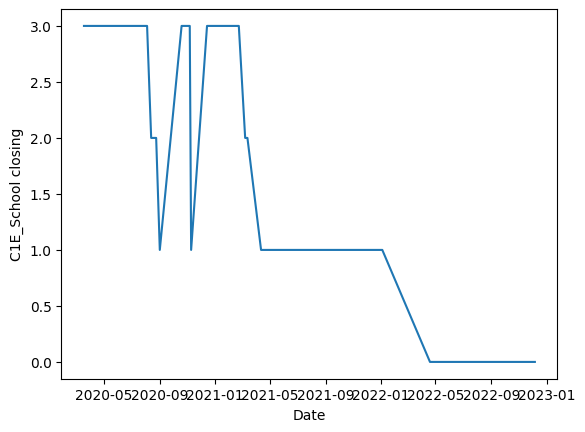

In [19]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(texas["Date"], format="%Y%m%d"), texas["Score"])
ax.set_xlabel("Date")
ax.set_ylabel("C1E_School closing")
plt.show()